In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import models

import seaborn as sns


In [3]:
data_dir = "mini_speech_commands"
commands = np.array(os.listdir(data_dir))

print(commands)


['right' 'go' 'left' 'stop' 'up' 'down']


In [4]:
filenames_pattern = data_dir + '/*/*'
filenames = glob.glob(filenames_pattern,recursive=True)
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print(len(filenames))

6000


In [5]:
num_samples = len(filenames)
print('Number of samples: ', num_samples)
print('Number of samples per class: ', num_samples//len(commands))
print('Examples of sample: ', filenames[0])

Number of samples:  6000
Number of samples per class:  1000
Examples of sample:  tf.Tensor(b'mini_speech_commands/go/3bfd30e6_nohash_4.wav', shape=(), dtype=string)


In [6]:
train_files = filenames[:4800]
valid_files = filenames[4800:4800 + 600]
test_files = filenames[-600:]
print('Train size: ', len(train_files))
print('Valid size: ', len(valid_files))
print('Test size: ', len(test_files))

Train size:  4800
Valid size:  600
Test size:  600


In [7]:
def decode_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

In [8]:
print (decode_audio(train_files[0]))

tf.Tensor(
[-0.00064087 -0.0007019  -0.00073242 ...  0.00085449  0.00109863
  0.00094604], shape=(16000,), dtype=float32)


In [9]:
def get_label(filepath):
    parts = tf.strings.split(
        input = filepath,
        sep=os.path.sep)
    return parts[-2]
    

In [10]:
print(get_label(train_files[0]))

tf.Tensor(b'go', shape=(), dtype=string)


In [11]:
def get_waveform_and_label(filepath):
    label = get_label(filepath)
    waveform = decode_audio(filepath)
    return waveform, label

In [12]:
print(get_waveform_and_label(train_files[0]))

(<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-0.00064087, -0.0007019 , -0.00073242, ...,  0.00085449,
        0.00109863,  0.00094604], dtype=float32)>, <tf.Tensor: shape=(), dtype=string, numpy=b'go'>)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label)

2024-05-05 13:06:20.740038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


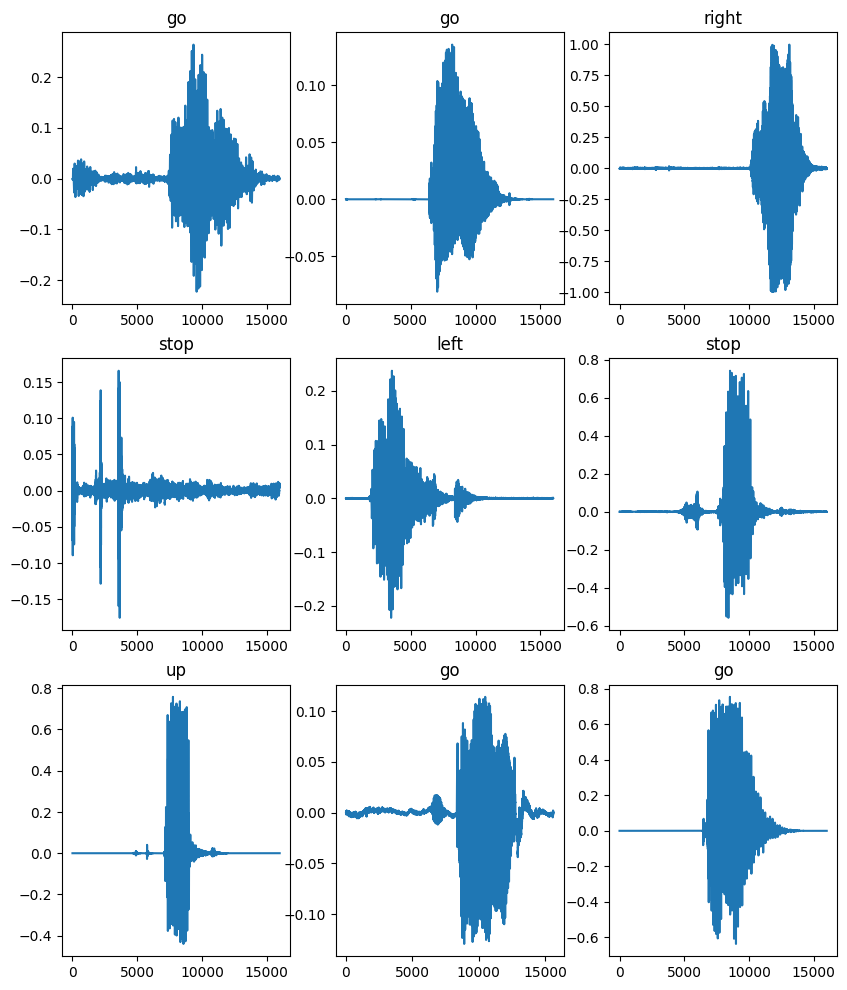

In [14]:
rows = 3
cols = 3
n = rows*cols

fig, axes = plt.subplots(rows, cols, figsize = (10,12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    label = label.numpy().decode('utf-8')
    ax.set_title(label)


In [15]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [input_len] - tf.shape(waveform),
        dtype = tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [61]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


2024-05-05 13:40:04.343909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [75]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


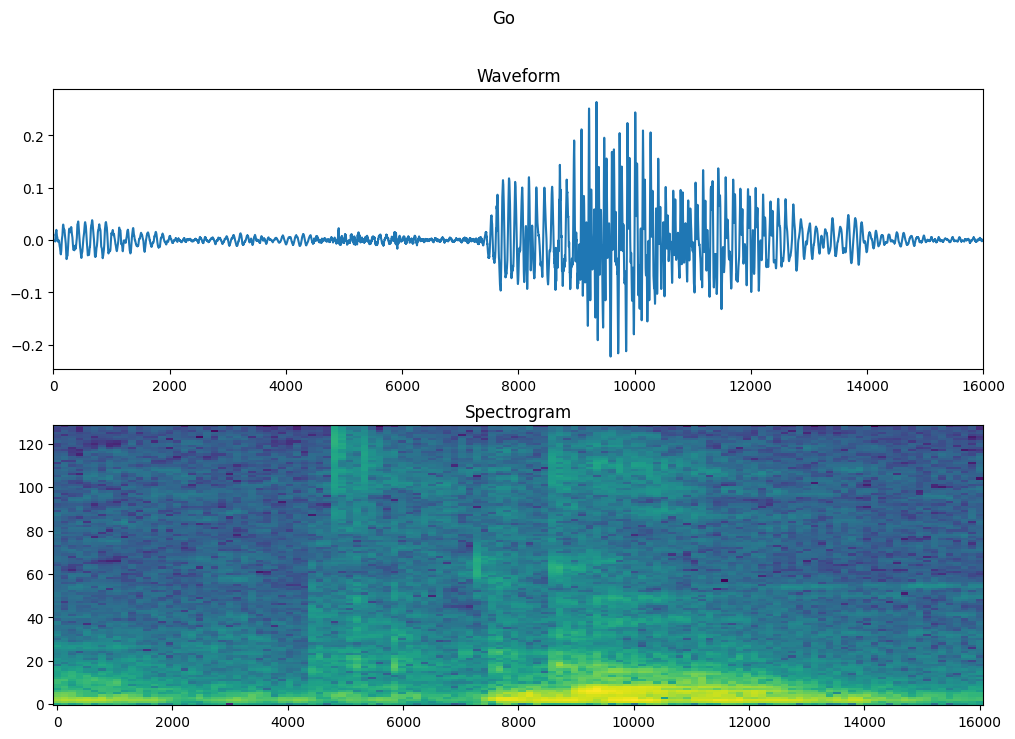

In [76]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])

axes[1].set_title('Spectrogram')

fig.suptitle(label.capitalize())


plt.savefig('waveform_and_spectrogram.jpeg')
plt.show()

In [19]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [20]:
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE)
    

2024-05-05 13:06:21.730277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


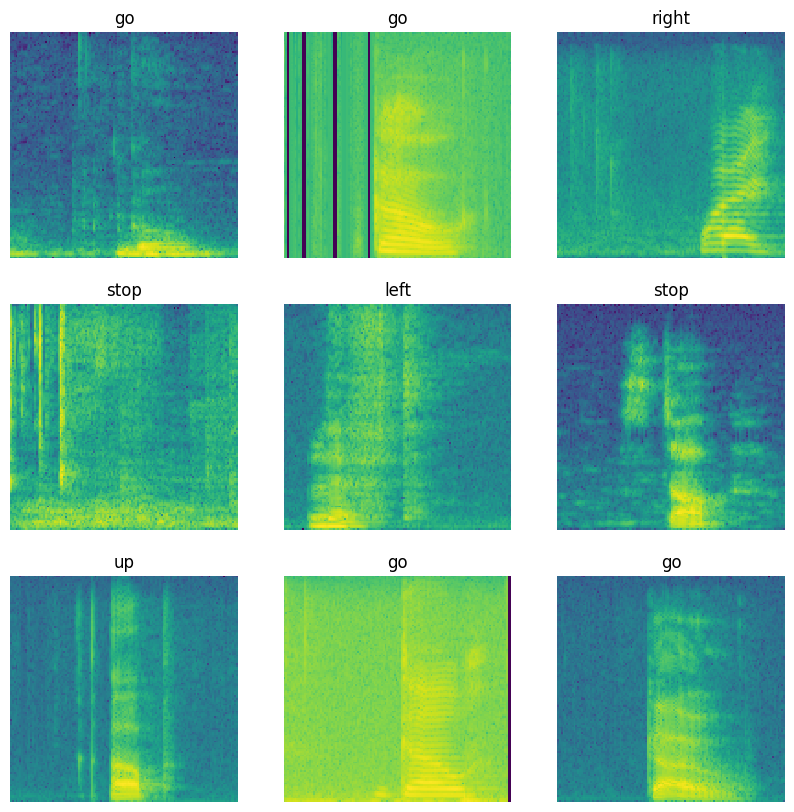

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
plt.savefig('spectrogram_plot.jpeg')
plt.show()

In [22]:

def preprocess_dataset(files):
    print(files)
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    print(files_ds)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    print(output_ds)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    print(output_ds)
    return output_ds

In [23]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(valid_files)
test_ds = preprocess_dataset(test_files)

tf.Tensor(
[b'mini_speech_commands/up/2fa39636_nohash_1.wav'
 b'mini_speech_commands/go/f15a354c_nohash_0.wav'
 b'mini_speech_commands/right/f216055e_nohash_1.wav'
 b'mini_speech_commands/up/f953e1af_nohash_3.wav'
 b'mini_speech_commands/right/152491bc_nohash_0.wav'
 b'mini_speech_commands/go/3e3fa7fd_nohash_1.wav'
 b'mini_speech_commands/go/e96a5020_nohash_1.wav'
 b'mini_speech_commands/up/98582fee_nohash_0.wav'
 b'mini_speech_commands/stop/f17be97f_nohash_4.wav'
 b'mini_speech_commands/left/531a5b8a_nohash_1.wav'
 b'mini_speech_commands/down/bf5d409d_nohash_0.wav'
 b'mini_speech_commands/left/b5552931_nohash_3.wav'
 b'mini_speech_commands/go/173ce2be_nohash_0.wav'
 b'mini_speech_commands/up/ef2a3cfb_nohash_1.wav'
 b'mini_speech_commands/go/d9462202_nohash_0.wav'
 b'mini_speech_commands/right/2cf28b70_nohash_0.wav'
 b'mini_speech_commands/up/59c3a7f2_nohash_0.wav'
 b'mini_speech_commands/right/c0c0d87d_nohash_0.wav'
 b'mini_speech_commands/go/49af4432_nohash_2.wav'
 b'mini_speech_comm

In [24]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [25]:
#train_ds = train_ds.cache().prefetch(AUTOTUNE)
# val_ds = val_ds.cache().prefetch(AUTOTUNE)
 

In [26]:
for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape[1:]
num_labels = len(commands)

2024-05-05 13:06:22.198787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-04-22 13:24:20.603724: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-22 13:24:20.611772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
print('Input shape: ', input_shape)
print('Number classes: ', num_labels)

Input shape:  (124, 129, 1)
Number classes:  6


In [28]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))


2024-05-05 13:06:25.100972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963,085 (3.67 MB)

 Trainable params: 962,184 (3.67 MB)

 Non-trainable params: 901 (3.52 KB)

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=7),
)

Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.2512 - loss: 2.2023 - val_accuracy: 0.2150 - val_loss: 1.8401
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.5150 - loss: 1.2913 - val_accuracy: 0.4000 - val_loss: 1.4024
Epoch 3/25
133/150 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.6819 - loss: 0.8816

KeyboardInterrupt: 

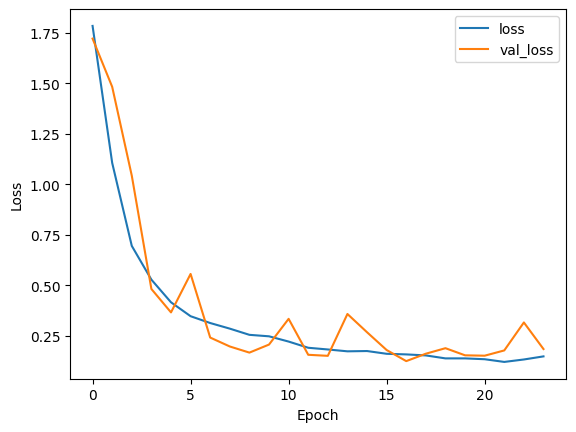

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.savefig('metrics_plot.jpeg')
plt.show()

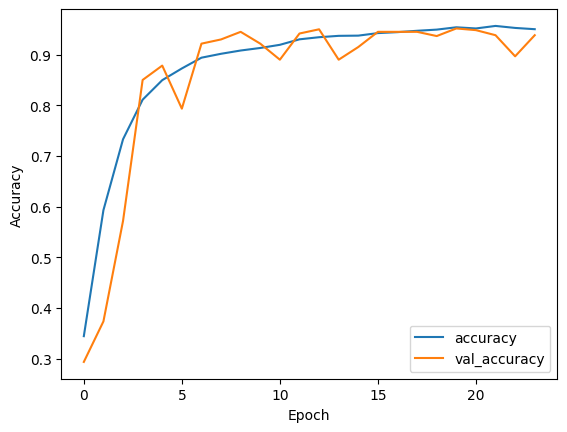

In [ ]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.savefig('metrics_accuracy_plot.jpeg')
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

2024-04-27 10:00:49.135726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Test set accuracy: 90%


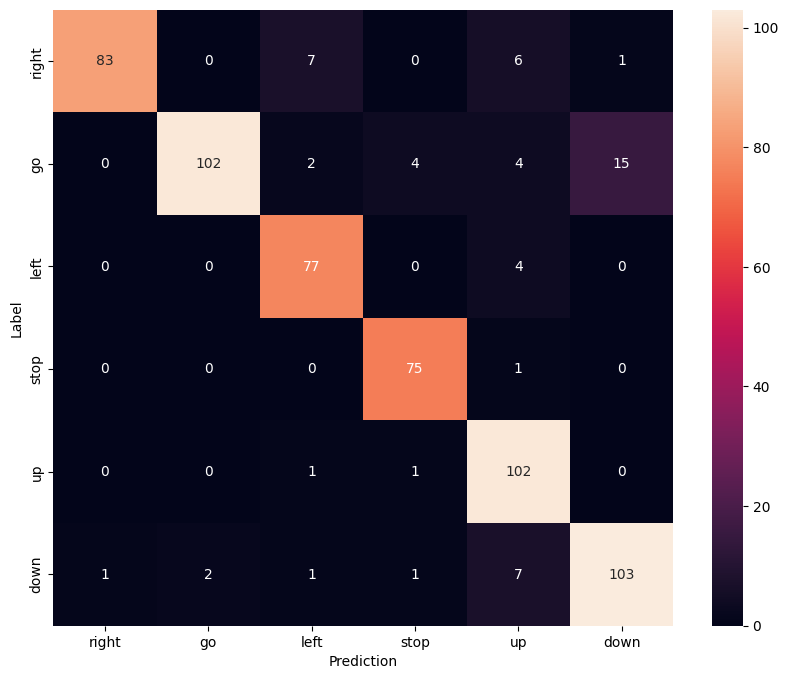

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')

plt.savefig('confusion_matrix.jpeg')


plt.show()

In [39]:
# import pyaudio
import numpy as np
import webrtcvad
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
import turtle

In [40]:
test_data_dir = './test_commands/'
manual_recordings = os.listdir(test_data_dir)
manual_recordings.remove('.DS_Store')
print(manual_recordings)
print(len(manual_recordings))


['go2.wav', 'left1.wav', 'go1.wav', 'left2.wav', 'down1.wav', 'down2.wav', 'stop2.wav', 'stop1.wav', 'up1.wav', 'up2.wav', 'right1.wav', 'right2.wav']
12


In [41]:
manual_recordings = [test_data_dir + rec for rec in manual_recordings]
print(manual_recordings)
print(len(manual_recordings))

['./test_commands/go2.wav', './test_commands/left1.wav', './test_commands/go1.wav', './test_commands/left2.wav', './test_commands/down1.wav', './test_commands/down2.wav', './test_commands/stop2.wav', './test_commands/stop1.wav', './test_commands/up1.wav', './test_commands/up2.wav', './test_commands/right1.wav', './test_commands/right2.wav']
12


In [42]:
def read_file(filepath):
    print(filepath)
    binary_file = tf.io.read_file(filepath)
    wav_file, _ = tf.audio.decode_wav(contents=binary_file)
    print(wav_file.shape)
    return wav_file

In [43]:
for rec in manual_recordings:
    read_file(rec)

./test_commands/go2.wav
(16347, 1)
./test_commands/left1.wav
(16347, 1)
./test_commands/go1.wav
(19928, 1)
./test_commands/left2.wav
(16347, 1)
./test_commands/down1.wav
(17833, 1)
./test_commands/down2.wav
(16347, 1)
./test_commands/stop2.wav
(16347, 1)
./test_commands/stop1.wav
(17833, 1)
./test_commands/up1.wav
(23789, 1)
./test_commands/up2.wav
(16347, 1)
./test_commands/right1.wav
(16347, 1)
./test_commands/right2.wav
(17833, 1)


In [91]:
def extract_files(filepathes):
    files=[]
    for filepath in filepathes:
        files.append(read_file(filepath))
    return files

In [92]:
files = extract_files(manual_recordings)

./test_commands/go2.wav
(16347, 1)
./test_commands/left1.wav
(16347, 1)
./test_commands/go1.wav
(19928, 1)
./test_commands/left2.wav
(16347, 1)
./test_commands/down1.wav
(17833, 1)
./test_commands/down2.wav
(16347, 1)
./test_commands/stop2.wav
(16347, 1)
./test_commands/stop1.wav
(17833, 1)
./test_commands/up1.wav
(23789, 1)
./test_commands/up2.wav
(16347, 1)
./test_commands/right1.wav
(16347, 1)
./test_commands/right2.wav
(17833, 1)


In [93]:
files

[<tf.Tensor: shape=(16347, 1), dtype=float32, numpy=
 array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.00048828],
        [ 0.        ],
        [ 0.00036621]], dtype=float32)>,
 <tf.Tensor: shape=(16347, 1), dtype=float32, numpy=
 array([[-0.0071106 ],
        [-0.00396729],
        [ 0.00430298],
        ...,
        [-0.00698853],
        [-0.0067749 ],
        [-0.0062561 ]], dtype=float32)>,
 <tf.Tensor: shape=(19928, 1), dtype=float32, numpy=
 array([[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.00524902],
        [0.00360107],
        [0.0050354 ]], dtype=float32)>,
 <tf.Tensor: shape=(16347, 1), dtype=float32, numpy=
 array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.00061035],
        [-0.00088501],
        [-0.00100708]], dtype=float32)>,
 <tf.Tensor: shape=(17833, 1), dtype=float32, numpy=
 array([[1.2207031e-03],
        [1.4953613e-03],
        [2.1667

In [94]:
def plot_waveform(waveform):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform)
    plt.title('Audio Waveform')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

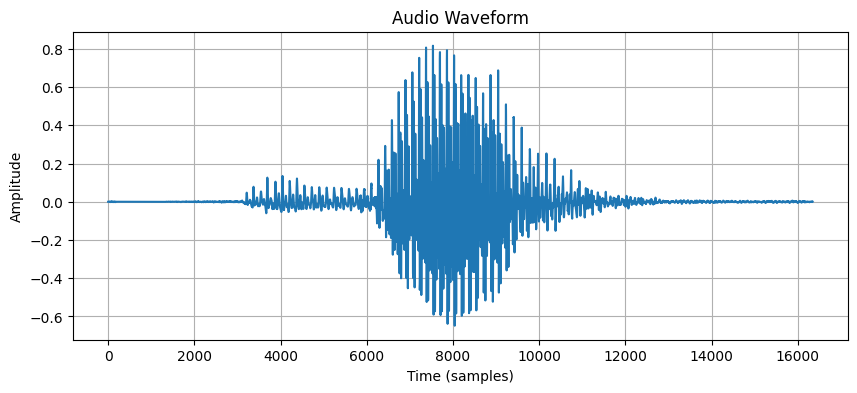

In [95]:
plot_waveform(files[0])

In [96]:
# files[0] = files[0][1000:15000]

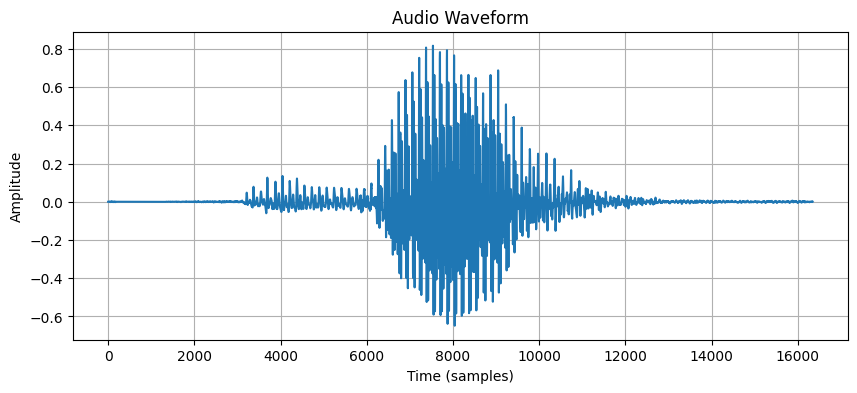

In [97]:
plot_waveform(files[0])

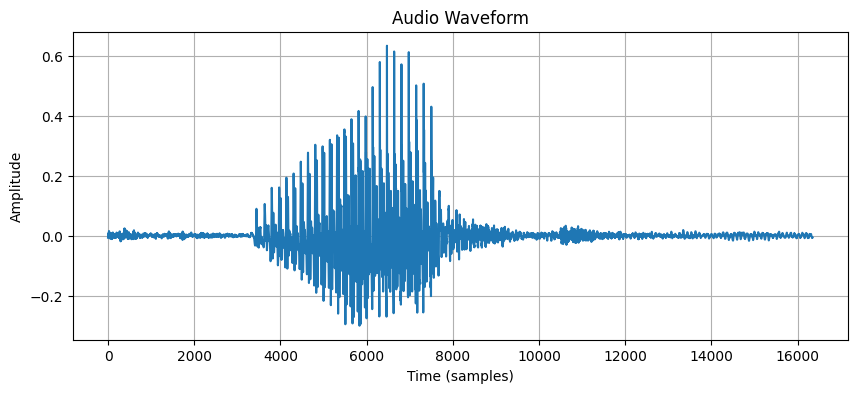

In [98]:
plot_waveform(files[1])

In [99]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [input_len] - tf.shape(waveform),
        dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [100]:
def preprocess_wave(waveform):
    print(waveform.shape)
    waveform=tf.squeeze(waveform, axis=-1)
    print(tf.shape(waveform), 'waveformshape after squeeze')
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    spectrogram = get_spectrogram(waveform)
    # spectrogram=tf.expand_dims(spectrogram, 0)
    return spectrogram
    

In [101]:
specs = []
for file in files:
    specs.append(preprocess_wave(file))

(16347, 1)
tf.Tensor([16347], shape=(1,), dtype=int32) waveformshape after squeeze
(16347, 1)
tf.Tensor([16347], shape=(1,), dtype=int32) waveformshape after squeeze
(19928, 1)
tf.Tensor([19928], shape=(1,), dtype=int32) waveformshape after squeeze
(16347, 1)
tf.Tensor([16347], shape=(1,), dtype=int32) waveformshape after squeeze
(17833, 1)
tf.Tensor([17833], shape=(1,), dtype=int32) waveformshape after squeeze
(16347, 1)
tf.Tensor([16347], shape=(1,), dtype=int32) waveformshape after squeeze
(16347, 1)
tf.Tensor([16347], shape=(1,), dtype=int32) waveformshape after squeeze
(17833, 1)
tf.Tensor([17833], shape=(1,), dtype=int32) waveformshape after squeeze
(23789, 1)
tf.Tensor([23789], shape=(1,), dtype=int32) waveformshape after squeeze
(16347, 1)
tf.Tensor([16347], shape=(1,), dtype=int32) waveformshape after squeeze
(16347, 1)
tf.Tensor([16347], shape=(1,), dtype=int32) waveformshape after squeeze
(17833, 1)
tf.Tensor([17833], shape=(1,), dtype=int32) waveformshape after squeeze


In [102]:
def plot_spectrogram(spectrogram):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    plt.pcolormesh(X, Y, log_spec)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

tf.Tensor([124 129   1], shape=(3,), dtype=int32)


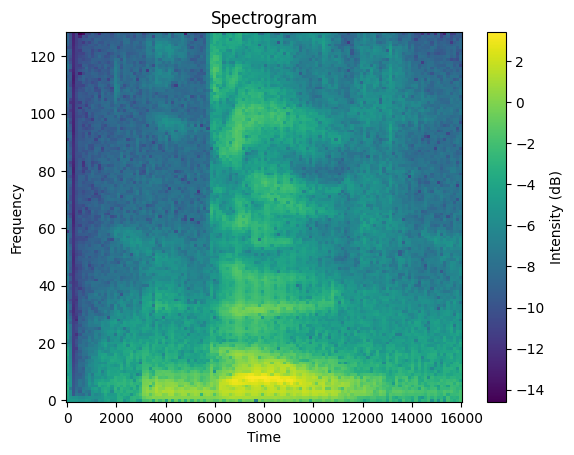

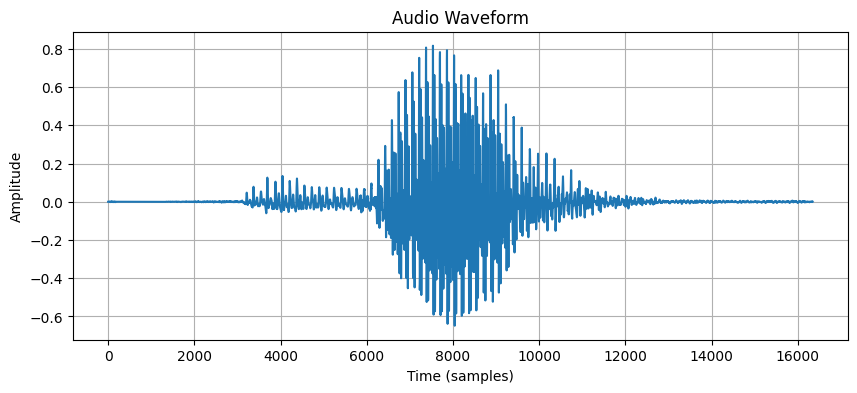

In [103]:
print(tf.shape(specs[0]))
plot_spectrogram(specs[0])
plot_waveform(files[0])

In [ ]:
def single_predict(spec):
    spec = tf.expand_dims(spec,0)
    predict = model(spec)
    confidence = np.max(tf.nn.softmax(predict))
    label_pred = np.argmax(predict, axis=1)
    command = commands[label_pred[0]]
    print(confidence, 'confidence')
    print(command, ': predicted')

In [ ]:
for spec in specs:
    single_predict(spec)

0.999765 confidence
go : predicted
0.99997365 confidence
left : predicted
0.99999905 confidence
go : predicted
0.9999974 confidence
left : predicted
0.9999958 confidence
down : predicted
1.0 confidence
down : predicted
0.99969184 confidence
stop : predicted
0.99956137 confidence
stop : predicted
0.98717684 confidence
up : predicted
0.9999794 confidence
up : predicted
1.0 confidence
right : predicted
1.0 confidence
right : predicted


In [ ]:
print(manual_recordings)

['/Users/macvejpazh/Desktop/test_commands/go2.wav', '/Users/macvejpazh/Desktop/test_commands/left1.wav', '/Users/macvejpazh/Desktop/test_commands/go1.wav', '/Users/macvejpazh/Desktop/test_commands/left2.wav', '/Users/macvejpazh/Desktop/test_commands/down1.wav', '/Users/macvejpazh/Desktop/test_commands/down2.wav', '/Users/macvejpazh/Desktop/test_commands/stop2.wav', '/Users/macvejpazh/Desktop/test_commands/stop1.wav', '/Users/macvejpazh/Desktop/test_commands/up1.wav', '/Users/macvejpazh/Desktop/test_commands/up2.wav', '/Users/macvejpazh/Desktop/test_commands/right1.wav', '/Users/macvejpazh/Desktop/test_commands/right2.wav']
